# Pretrain Levi Hassner Model on CelebA for Gender Classification on Adience Dataset

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import seaborn as sns
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils import np_utils

import tensorflow as tf
print(tf.__version__)

/mnt/local/yuxin/anaconda3/envs/gender/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-10 22:07:40.837921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


# Preprocess CelebA Dataset

In [19]:
train_datagen = ImageDataGenerator( # Data Augumentation for test data
                                    rescale=1./255,
                                    rotation_range=0,
                                    shear_range=0.3,
                                    zoom_range=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_gen = train_datagen.flow_from_directory('./CelebA_Dataset/Train',
                                            target_size=(227, 227),
                                            batch_size=32,
                                            class_mode='binary')

valid_gen = test_datagen.flow_from_directory('./CelebA_Dataset/Validation',
                                           target_size=(227, 227),
                                           batch_size=32,
                                           class_mode='binary')

test_gen = test_datagen.flow_from_directory('./CelebA_Dataset/Test',
                                           target_size=(227, 227),
                                           batch_size=32,
                                           class_mode='binary')

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


# Create Model
---
## Hyperparameters

In [28]:
batch_size = 32
epochs = 20
target_size = (227, 227) # (64, 64)
input_shape = (227, 227, 3) #(64, 64, 3)

# random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [29]:
import math

weight_init = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=SEED)

In [30]:
# Define baseline model builder
def build_LeviHassner():
    model = keras.models.Sequential()
    
    # conv1: 96 filters, 7x7 kernel, stride=4, valid padding
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(96, (7,7), input_shape=input_shape, strides=4, padding='valid', 
                     activation='relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size=(3, 3), strides=2, padding='same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # conv2: 256 filters, 5x5 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(256, (5,5), padding='same', activation = 'relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size = (3, 3), strides = 2,padding = 'same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # conv3: 384 filters, 3x3 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    model.add(keras.layers.Conv2D(384,(3,3),padding='same',activation='relu',kernel_initializer=weight_init))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
    
    # flatten
    model.add(Flatten())
    
    # fc1 + dropout
    model.add(Dense(512, activation="relu", kernel_initializer=weight_init))
    model.add(Dropout(0.5))
    
    # fc2 + dropout
    model.add(Dense(512, activation='relu', kernel_initializer=weight_init))
    model.add(Dropout(0.5))
    
    # fc3
    model.add(Dense(1, activation ='sigmoid', kernel_initializer=weight_init))

    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 384)      

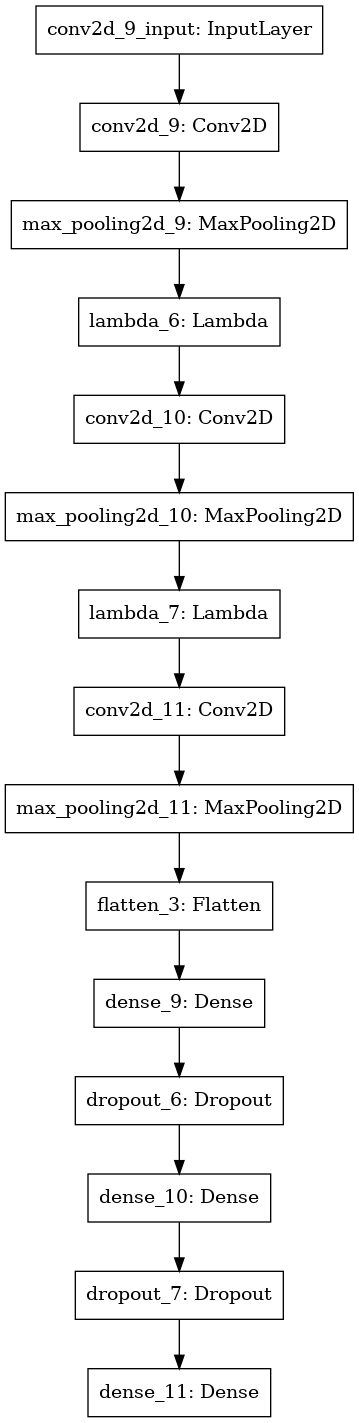

In [31]:
# Visualize the model
from tensorflow.keras.utils import plot_model

model = build_LeviHassner()
model.summary()
plot_model(model)

In [32]:
def get_call_backs():
    """
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)
    """
    lrate = keras.callbacks.LearningRateScheduler(step_decay)
    
    mcp = ModelCheckpoint('celebA-model.h5')

    es = EarlyStopping(verbose=verbose, patience=patience)
    
    return [lrate, mcp, es]

# compile the model
# !!!!!!!! learning rate !!!!!!!!
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# training
history = model.fit(
    train_gen, 
    batch_size=batch_size, 
    epochs=epochs,
    steps_per_epoch=70,
    validation_steps=50,
    validation_data=valid_gen, 
    callbacks=get_call_backs())

Epoch 1/20
70/70 [==============================] - 33s 469ms/step - loss: 0.6891 - accuracy: 0.5845 - val_loss: 0.6695 - val_accuracy: 0.6150
Epoch 2/20
70/70 [==============================] - 29s 421ms/step - loss: 0.6733 - accuracy: 0.5994 - val_loss: 0.5773 - val_accuracy: 0.7194
Epoch 3/20
70/70 [==============================] - 33s 460ms/step - loss: 0.5987 - accuracy: 0.7180 - val_loss: 0.5338 - val_accuracy: 0.7469
Epoch 4/20
70/70 [==============================] - 32s 457ms/step - loss: 0.5640 - accuracy: 0.7306 - val_loss: 0.5254 - val_accuracy: 0.7831
Epoch 5/20
70/70 [==============================] - 32s 461ms/step - loss: 0.5243 - accuracy: 0.7769 - val_loss: 0.5373 - val_accuracy: 0.7281
Epoch 6/20
70/70 [==============================] - 31s 445ms/step - loss: 0.5192 - accuracy: 0.7474 - val_loss: 0.4175 - val_accuracy: 0.8019
Epoch 7/20
70/70 [==============================] - 31s 437ms/step - loss: 0.4532 - accuracy: 0.7946 - val_loss: 0.4329 - val_accuracy: 0.8244

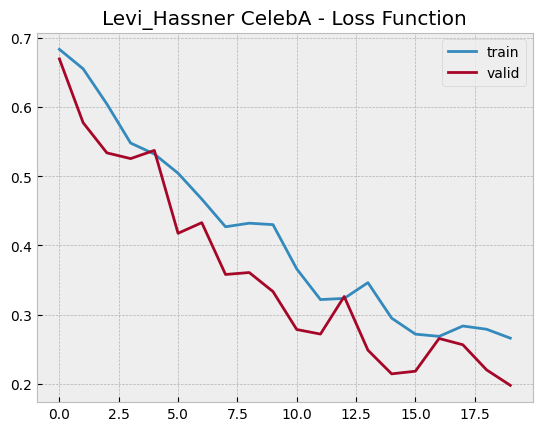

In [34]:
plt.style.use("bmh")

# Plot loss function value through epochs
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')

plt.legend(loc='upper right')
plt.title('Levi_Hassner CelebA - Loss Function')
plt.show()

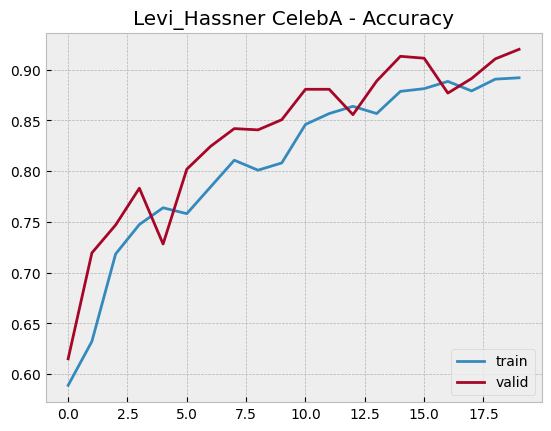

In [35]:
# Plot accuracy through epochs

plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')

plt.legend(loc='lower right')
plt.title('Levi_Hassner CelebA - Accuracy')
plt.show()

In [ ]:
# test
# test_loss, test_acc = model.evaluate(test_gen, verbose=2)
# print(test_acc)

# Preprocess Adience Dataset

In [37]:
# load data
ADIENCE_PATH = './Adience'
print(os.listdir(path=ADIENCE_PATH))

all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )

['AdienceBenchmarkGenderAndAgeClassification', 'faces', 'fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt', '__MACOSX']


In [38]:
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [39]:
df = total_data[['gender', 'x', 'y', 'dx', 'dy']].copy()

img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gender    18591 non-null  object
 1   x         19370 non-null  int64 
 2   y         19370 non-null  int64 
 3   dx        19370 non-null  int64 
 4   dy        19370 non-null  int64 
 5   img_path  19370 non-null  object
dtypes: int64(4), object(2)
memory usage: 908.1+ KB


In [40]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17492 entries, 0 to 19345
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gender    17492 non-null  object
 1   x         17492 non-null  int64 
 2   y         17492 non-null  int64 
 3   dx        17492 non-null  int64 
 4   dy        17492 non-null  int64 
 5   img_path  17492 non-null  object
dtypes: int64(4), object(2)
memory usage: 956.6+ KB


In [41]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,gender,x,y,dx,dy,img_path
0,0,0,414,1086,1383,./Adience/faces/30601258@N03/coarse_tilt_align...
1,1,301,105,640,641,./Adience/faces/30601258@N03/coarse_tilt_align...
2,0,2395,876,771,771,./Adience/faces/30601258@N03/coarse_tilt_align...
3,1,752,1255,484,485,./Adience/faces/30601258@N03/coarse_tilt_align...
4,1,175,80,769,768,./Adience/faces/30601258@N03/coarse_tilt_align...


# Create Dataset

In [42]:
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12244, 1)
Test data shape (5248, 1)


In [43]:
print(y_test)

       gender
3016        0
2736        1
247         0
16350       1
17856       0
...       ...
3338        0
3009        0
12387       0
7654        1
6668        0

[5248 rows x 1 columns]


In [44]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    # TODO: np.float
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12244, 227, 227, 3)
Test images shape (5248, 227, 227, 3)


# Finetune Model

In [45]:
import math

def step_decay(epoch):
    init_lrate = 1e-3 
    drop = 0.1
    epochs_drop = 10000
    lrate = init_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def get_call_backs():
    """
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)
    """
    lrate = keras.callbacks.LearningRateScheduler(step_decay)
    
    mcp = ModelCheckpoint('pretrain_lev_hassner.h5')

    es = EarlyStopping(verbose=verbose, patience=3)
    
    return [lrate, mcp, es]

In [47]:
# recompile the model to change the optimizer
model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
# finetuning
history = model.fit(
    train_images, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, y_test), 
    callbacks=get_call_backs())

2022-11-10 23:01:50.994200: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1892763228 exceeds 10% of free system memory.


Epoch 1/20
383/383 [==============================] - 6s 14ms/step - loss: 0.4340 - accuracy: 0.7961 - val_loss: 0.4980 - val_accuracy: 0.7540
Epoch 2/20
383/383 [==============================] - 5s 14ms/step - loss: 0.4402 - accuracy: 0.7943 - val_loss: 0.4880 - val_accuracy: 0.7616
Epoch 3/20
383/383 [==============================] - 5s 14ms/step - loss: 0.4325 - accuracy: 0.7936 - val_loss: 0.4727 - val_accuracy: 0.7700
Epoch 4/20
383/383 [==============================] - 5s 14ms/step - loss: 0.4192 - accuracy: 0.8022 - val_loss: 0.4888 - val_accuracy: 0.7595
Epoch 5/20
383/383 [==============================] - 5s 14ms/step - loss: 0.4068 - accuracy: 0.8081 - val_loss: 0.4668 - val_accuracy: 0.7725
Epoch 6/20
383/383 [==============================] - 5s 14ms/step - loss: 0.3983 - accuracy: 0.8152 - val_loss: 0.4654 - val_accuracy: 0.7788
Epoch 7/20
383/383 [==============================] - 5s 14ms/step - loss: 0.3889 - accuracy: 0.8179 - val_loss: 0.4992 - val_accuracy: 0.7736

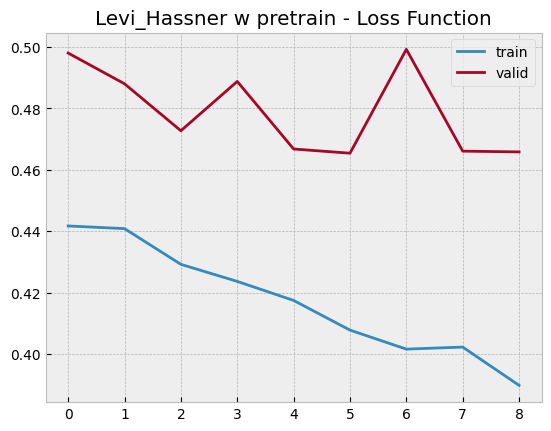

In [48]:
plt.style.use("bmh")

# Plot loss function value through epochs
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')

plt.legend(loc='upper right')
plt.title('Levi_Hassner w pretrain - Loss Function')
plt.show()

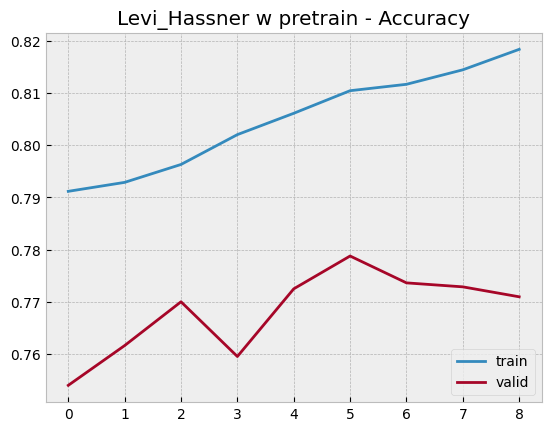

In [49]:
# Plot accuracy through epochs

plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')

plt.legend(loc='lower right')
plt.title('Levi_Hassner w pretrain - Accuracy')
plt.show()

In [50]:
# test
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 1s - loss: 0.4658 - accuracy: 0.7710
0.7709603905677795


In [51]:
# recompile the model to change the learning rate -> 1e-4
model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
# finetuning
history = model.fit(
    train_images, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, y_test), 
    callbacks=get_call_backs())

2022-11-10 23:05:54.777408: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1892763228 exceeds 10% of free system memory.


Epoch 1/20
383/383 [==============================] - 6s 15ms/step - loss: 0.3727 - accuracy: 0.8296 - val_loss: 0.4594 - val_accuracy: 0.7801
Epoch 2/20
383/383 [==============================] - 5s 14ms/step - loss: 0.3765 - accuracy: 0.8240 - val_loss: 0.4804 - val_accuracy: 0.7620
Epoch 3/20
383/383 [==============================] - 5s 14ms/step - loss: 0.3814 - accuracy: 0.8258 - val_loss: 0.4454 - val_accuracy: 0.7784
Epoch 4/20
383/383 [==============================] - 5s 14ms/step - loss: 0.3533 - accuracy: 0.8379 - val_loss: 0.4823 - val_accuracy: 0.7685
Epoch 5/20
383/383 [==============================] - 5s 14ms/step - loss: 0.3524 - accuracy: 0.8396 - val_loss: 0.4567 - val_accuracy: 0.7906
Epoch 6/20
383/383 [==============================] - 5s 14ms/step - loss: 0.3511 - accuracy: 0.8409 - val_loss: 0.4588 - val_accuracy: 0.7866
Epoch 00006: early stopping


In [52]:
# test
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 1s - loss: 0.4588 - accuracy: 0.7866
0.7865853905677795
